In [24]:
# Imports
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering, ward_tree, OPTICS, SpectralClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.neighbors import kneighbors_graph
from skimage.feature import structure_tensor, structure_tensor_eigenvalues, canny
from skimage.color import rgb2gray, rgb2hsv, label2rgb
import matplotlib.pyplot as plt
from skimage.measure import label
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels
from time import time

from skimage import data, io, segmentation, color
from skimage import graph



IMG_SIZE = 350
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = tr.get_input_transform(IMG_SIZE, IMG_SIZE)


In [2]:
from hr_dv2 import HighResDV2

net = HighResDV2("dinov2_vits14_reg", 4, dtype=torch.float16)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [27]:
shift_dists = [i for i in range(1, 3)]
#transforms, inv_transforms = tr.get_rotation_transforms()
fwd_flip, inv_flip = tr.get_flip_transforms()
fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
fwd, inv = fwd_flip, inv_flip
fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
net.set_transforms(fwd, inv)

In [28]:
LABEL_CONFIDENCE = 0.7
SXY_G, SXY_B = (3, 3), (80, 80)
SRGB = (13, 13, 13)
COMPAT_G, COMPAT_B = 10, 10
KERNEL = dcrf.FULL_KERNEL

def find_fg_mask(seg: np.ndarray, verbose=False) -> np.ndarray:
    # ASSUMES BG SPANS WHOLE IMAGE AND FG DOESN'T
    seg = seg.astype(bool)
    h, w, c = seg.shape
    seg_area = h * w
    masks = [seg, ~seg]
    areas = []
    bg_idx = 0
    if verbose:
        print(f"Seg area={seg_area}")
    for i, m in enumerate(masks):
        idxs = np.nonzero(m)
        min_y, max_y = np.amin(idxs[0]), np.amax(idxs[0])
        min_x, max_x = np.amin(idxs[1]), np.amax(idxs[1])
        area = (max_x - min_x) * (max_y - min_y)
        if verbose:
            print(f"{i}: area={area} ({min_x}, {min_y}, {max_x}, {max_y})")
        areas.append(area)
    bg_idx = int(np.argmax(areas))
    return masks[1 - bg_idx]

    

def object_segment(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, k: int=2, condense: bool=True, single_component: bool=True, 
                   verbose: bool=False) -> np.ndarray:
    start = time()
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    if condense:
        standard = standardize_img(reshaped)
        pca = PCA(n_components=70, svd_solver='randomized', n_oversamples=5, iterated_power=3)
        pca.fit(standard)
        standard = pca.transform(standard)
        normed = normalise_pca(standard)
    else:
        normed = normalise_pca(reshaped)

    cluster = KMeans(n_clusters=k, n_init='auto')
    cluster.fit(normed)
    k_means_labels = cluster.labels_

    unary = unary_from_labels(k_means_labels, k, LABEL_CONFIDENCE, zero_unsure=False)
    d = dcrf.DenseCRF2D(iw, ih, k)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((ih, iw, 1))
    fg_seg = find_fg_mask(crf_seg, verbose=verbose)
    fg_seg = fg_seg.astype(np.uint8)
    if single_component:
        labels, n_components = label(fg_seg, background=0, return_num=True)
        fg_seg = labels == np.argmax(np.bincount(labels.flat, weights=fg_seg.flat))
    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return fg_seg

def elbow(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, k: int=3, 
                   verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:
    start = time()
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    standard = standardize_img(reshaped)
    pca = PCA(n_components=k, svd_solver='randomized', n_oversamples=5, iterated_power=3)
    pca.fit(standard)
    standard = pca.transform(standard)

    x, y = np.arange(0, iw), np.arange(0, ih)
    X2D,Y2D = np.meshgrid(x, y)
    spatial_feats = np.column_stack((Y2D.ravel(), X2D.ravel()))
    #print(spatial_feats.shape, standard.shape)

    normed = normalise_pca(standard)
    normed_2D = normed.reshape((ih, iw, k))
    normed = np.concatenate((normed, normalise_pca(spatial_feats)), axis=-1)
    

    labels, centres, scores = [], [], []
    for n in range(2, 7):
        cluster = KMeans(n_clusters=n, n_init='auto', max_iter=300)
        label = cluster.fit_predict(normed)
        centre = cluster.cluster_centers_
        score = calinski_harabasz_score(normed, label)
        labels.append(label)
        centres.append(centre)
        scores.append(score)
    best_score = np.amax(scores)
    best_score_idx = int(np.argmax(scores))
    best_labels = labels[best_score_idx]

    end = time()
    if verbose:
        print(f"Finished in {end-start}s, best score {best_score} at cluster k={2+best_score_idx}")
    return normed_2D, best_labels.reshape((ih, iw, 1))

def RAG(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, k: int=3, 
                   verbose: bool=False) -> Tuple[np.ndarray, np.ndarray]:   
    """
    This seems to be working relatively well. Pipeline is:
    1) HRDv2 for features
    2) PCA down to 3 components
    3) SLIC superpixel segmentation (i.e k-means in colour space)    
    could just k-means?
    => n class segmentation
    4) CRF to improve segmentation (using labels rather than confidence)

    Could really replace 3 with anything that clusters the features and considers spatial
    effects. Need to try varying PCA n_dim, SLIC parameters, CRF parameters

    :param net: _description_
    :type net: HighResDV2
    :param img_arr: _description_
    :type img_arr: np.ndarray
    :param img_tensor: _description_
    :type img_tensor: torch.Tensor
    :param k: _description_, defaults to 3
    :type k: int, optional
    :param verbose: _description_, defaults to False
    :type verbose: bool, optional
    :return: _description_
    :rtype: Tuple[np.ndarray, np.ndarray]
    """
    def _weight_mean_color(graph, src, dst, n):
        diff = graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color']
        diff = np.linalg.norm(diff)
        return {'weight': diff}
    
    def merge_mean_color(graph, src, dst):
        graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
        graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
        graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                        graph.nodes[dst]['pixel count'])

    start = time()
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward_sequential(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    standard = standardize_img(reshaped)
    pca = PCA(n_components=k, svd_solver='randomized', n_oversamples=5, iterated_power=3)
    pca.fit(standard)
    standard = pca.transform(standard)
    rescaled = rescale_pca(standard).reshape((ih, iw, k))
    rescaled = (255 * rescaled).astype(np.uint8)

    labels = segmentation.slic(rescaled, compactness=30, n_segments=400, start_label=0, convert2lab=True, sigma=1, enforce_connectivity=False)
    g = graph.rag_mean_color(rescaled, labels)

    labels2 = graph.merge_hierarchical(labels, g, thresh=110, rag_copy=False,
                                    in_place_merge=True,
                                    merge_func=merge_mean_color,
                                    weight_func=_weight_mean_color)
    
    n_classes = np.amax(labels2) + 1
    unary = unary_from_labels(labels2, n_classes, LABEL_CONFIDENCE, zero_unsure=False)
    d = dcrf.DenseCRF2D(iw, ih, n_classes)
    u = np.ascontiguousarray(unary)
    d.setUnaryEnergy(u)
    d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)
    d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    crf_seg = np.argmax(Q, axis=0)
    crf_seg = crf_seg.reshape((ih, iw, 1))
    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return rescaled, crf_seg#labels2


def fused_clustering(net: HighResDV2, img_arr: np.ndarray, img_tensor: torch.Tensor, n_clusters: List[int]=[4], k_pca: int=6, 
                   verbose: bool=False) -> List[np.ndarray]:   
    start = time()
    ih, iw, ic = img_arr.shape
    hr_tensor, _ = net.forward_sequential(img_tensor, attn='none')
    features: np.ndarray
    b, c, fh, fw = hr_tensor.shape
    features = tr.to_numpy(hr_tensor)
    reshaped = features.reshape((c, fh * fw)).T

    standard = standardize_img(reshaped)
    pca = PCA(n_components=k_pca, svd_solver='randomized', n_oversamples=5, iterated_power=3)
    pca.fit(standard)
    standard = pca.transform(standard)
    rescaled = rescale_pca(standard)

    hsv = rgb2hsv(img_arr)
    c_h, c_s, c_v = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
    x, y = np.arange(0, iw), np.arange(0, ih)
    p_x, p_y = np.meshgrid(x, y)
    color_matting = np.stack((np.cos(c_h), np.sin(c_h), c_s, c_v, p_x, p_y))
    color_matting_flat = color_matting.reshape((6, ih * iw)).T
    color_matting_rescaled = rescale_pca(color_matting_flat)

    fused = np.concatenate((rescaled, color_matting_rescaled), axis=-1)
    print(fused.shape)
    segs = []
    for n in n_clusters:
        cluster = KMeans(n_clusters=n, n_init='auto')
        cluster.fit(fused)
        labels = cluster.labels_
        
        unary = unary_from_labels(labels, n, LABEL_CONFIDENCE, zero_unsure=False)
        d = dcrf.DenseCRF2D(iw, ih, n)
        u = np.ascontiguousarray(unary)
        d.setUnaryEnergy(u)
        d.addPairwiseGaussian(sxy=SXY_G, compat=COMPAT_G, kernel=KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)
        d.addPairwiseBilateral(sxy=SXY_B, srgb=SRGB, rgbim=img_arr, compat=COMPAT_B, kernel=KERNEL,
                                normalization=dcrf.NORMALIZE_SYMMETRIC)
        Q = d.inference(10)
        crf_seg = np.argmax(Q, axis=0)
        crf_seg = crf_seg.reshape((ih, iw, 1))
        segs.append(crf_seg)
    end = time()
    if verbose:
        print(f"Finished in {end-start}s")
    return segs




In [5]:
img_paths = ["data/d3.jpg", "data/plane.jpg", "data/f1.jpg", "data/coffee.png", "data/c1.jpg"]
masks, imgs = [], []

for i, path in enumerate(img_paths):
    tensor, img = tr.load_image(path, transform)
    tensor.to(torch.float16)
    tensor = tensor.cuda()

    fg_seg = object_segment(net, np.array(img), tensor, k=2, condense=False, single_component=False, verbose=True)
    tensor = tensor.cpu()

    imgs.append(img)
    masks.append(fg_seg)

Seg area=122500
0: area=121801 (0, 0, 349, 349)
1: area=49737 (72, 68, 249, 349)
Finished in 3.8458914756774902s
Seg area=122500
0: area=121801 (0, 0, 349, 349)
1: area=32376 (121, 146, 349, 288)
Finished in 2.999744176864624s
Seg area=122500
0: area=121801 (0, 0, 349, 349)
1: area=91613 (0, 41, 317, 330)
Finished in 2.3257524967193604s
Seg area=122500
0: area=121801 (0, 0, 349, 349)
1: area=88494 (29, 23, 330, 317)
Finished in 2.2984659671783447s
Seg area=122500
0: area=121801 (0, 0, 349, 349)
1: area=121801 (0, 0, 349, 349)
Finished in 2.448889970779419s


Text(0.5, 0.8, 'Foreground object segmentation from DINOv2 features')

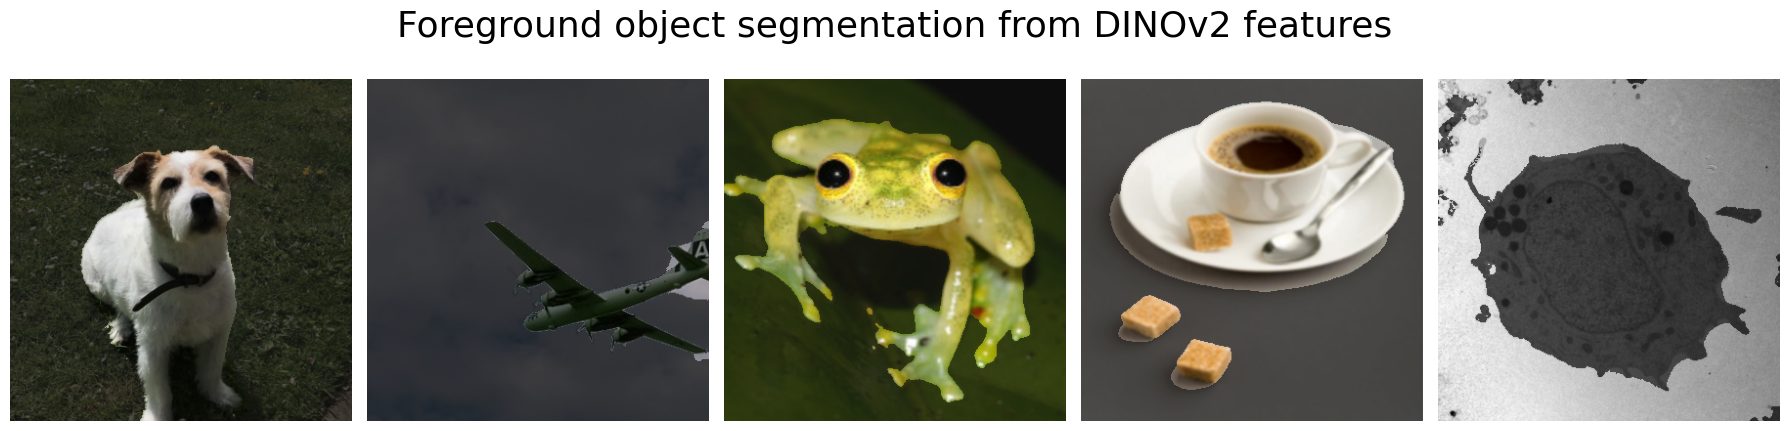

In [6]:
fig, axs = plt.subplots(ncols=len(img_paths))
fig.set_size_inches(18, 8)

for i, img in enumerate(imgs):
    ax = axs[i]
    mask = masks[i]
    alpha_mask = np.where(mask == 1, [1, 1, 1, 1], [0.35, 0.35, 0.35, 0.95])
    img = img.convert("RGBA")
    masked = (img * alpha_mask).astype(np.uint8)
    ax.imshow(masked)
    ax.set_axis_off()
fig.tight_layout()
fig.suptitle("Foreground object segmentation from DINOv2 features", fontsize=26, y=0.8)

In [43]:
voc_paths = [f"data/v{i}.jpg" for i in range(20, 25)] #+ [f"data/d3_old.jpg", "data/plane.jpg", "data/f1.jpg"]
#voc_paths = [f"data/v{i}.jpg" for i in range(20, 25)]
voc_pcas, voc_eigvals, voc_imgs, voc_segs = [], [], [], []

In [44]:
voc_imgs, voc_segs = [], []
clusters = [2, 3, 4, 5, 6, 7, 8]
for i, path in enumerate(voc_paths):
    _img = Image.open(path)
    h, w = _img.height, _img.width
    if 'v' not in path:
        t = transform
    else:
        t = tr.closest_crop(h, w, 14, True)
    tensor, img = tr.load_image(path, t)

    tensor.to(torch.float16)
    tensor = tensor.cuda()

    segs = fused_clustering(net, np.array(img), tensor, k_pca=6, n_clusters=clusters, verbose=True)
    tensor = tensor.cpu()

    voc_imgs.append(img)
    voc_segs.append(segs)

(178360, 12)
Finished in 30.184226274490356s
(157780, 12)
Finished in 22.46180272102356s
(178360, 12)
Finished in 27.06461477279663s
(178360, 12)
Finished in 27.20024061203003s
(173264, 12)
Finished in 29.188801050186157s


(5, 8)


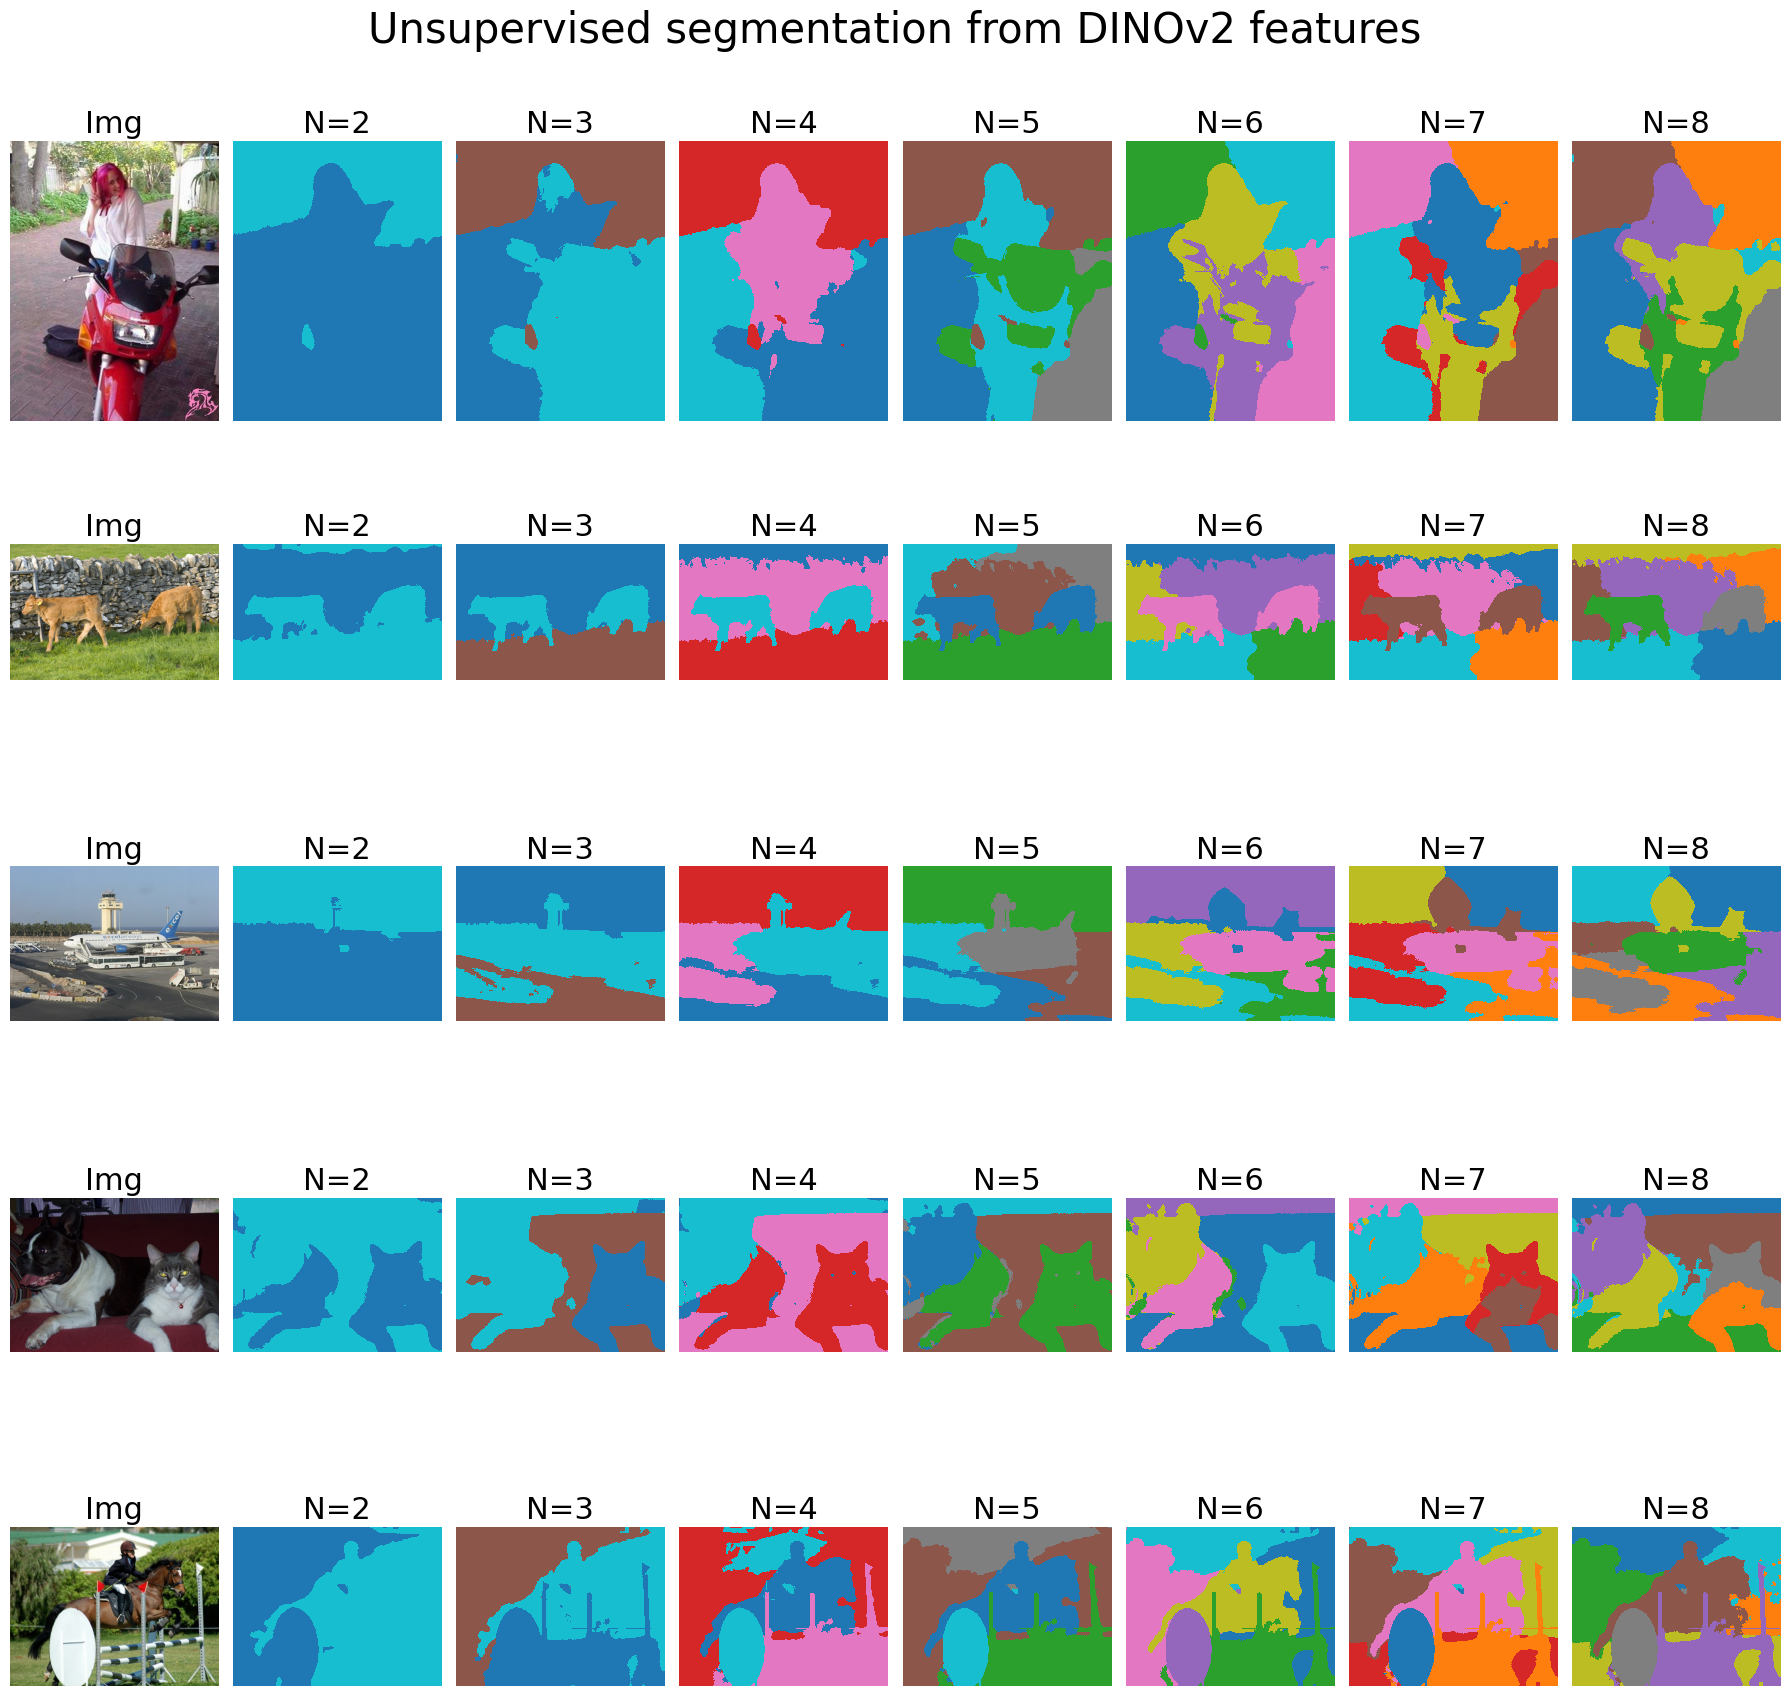

In [45]:
N_COLS = len(clusters) + 1
N_ROWS = len(voc_paths)
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(18, 18)
print(axs.shape)

plt.suptitle("Unsupervised segmentation from DINOv2 features", fontsize=30, y=1.0)

I = 0
for i in range(0, len(voc_paths)):
    img = np.asarray(voc_imgs[i])
    h, w, c = img.shape
    row = axs[i]
    for j, arr in enumerate([img] + voc_segs[i]):
        ax = row[j]
        
        title = "Img"
        if j > 0:
            arr = arr.reshape((h, w)) + 1
            title = f"N={clusters[j - 1]}"
            ax.imshow(arr, cmap='tab10', interpolation='nearest')
        else:
            ax.imshow(arr)
            
            #arr = label2rgb(arr, img, kind='avg')
        
        ax.set_title(title, fontsize=22)
        ax.set_axis_off()
plt.tight_layout()

In [6]:
voc_pcas, voc_eigvals, voc_imgs, voc_segs = [], [], [], []
for i, path in enumerate(voc_paths):
    _img = Image.open(path)
    h, w = _img.height, _img.width
    if 'v' not in path:
        t = transform
    else:
        t = tr.closest_crop(h, w, 14, True)
    tensor, img = tr.load_image(path, t)

    tensor.to(torch.float16)
    tensor = tensor.cuda()

    pca, seg = RAG(net, np.array(img), tensor, k=3, verbose=False)
    tensor = tensor.cpu()

    voc_imgs.append(img)
    voc_pcas.append(pca)
    voc_segs.append(seg)

(11, 4)


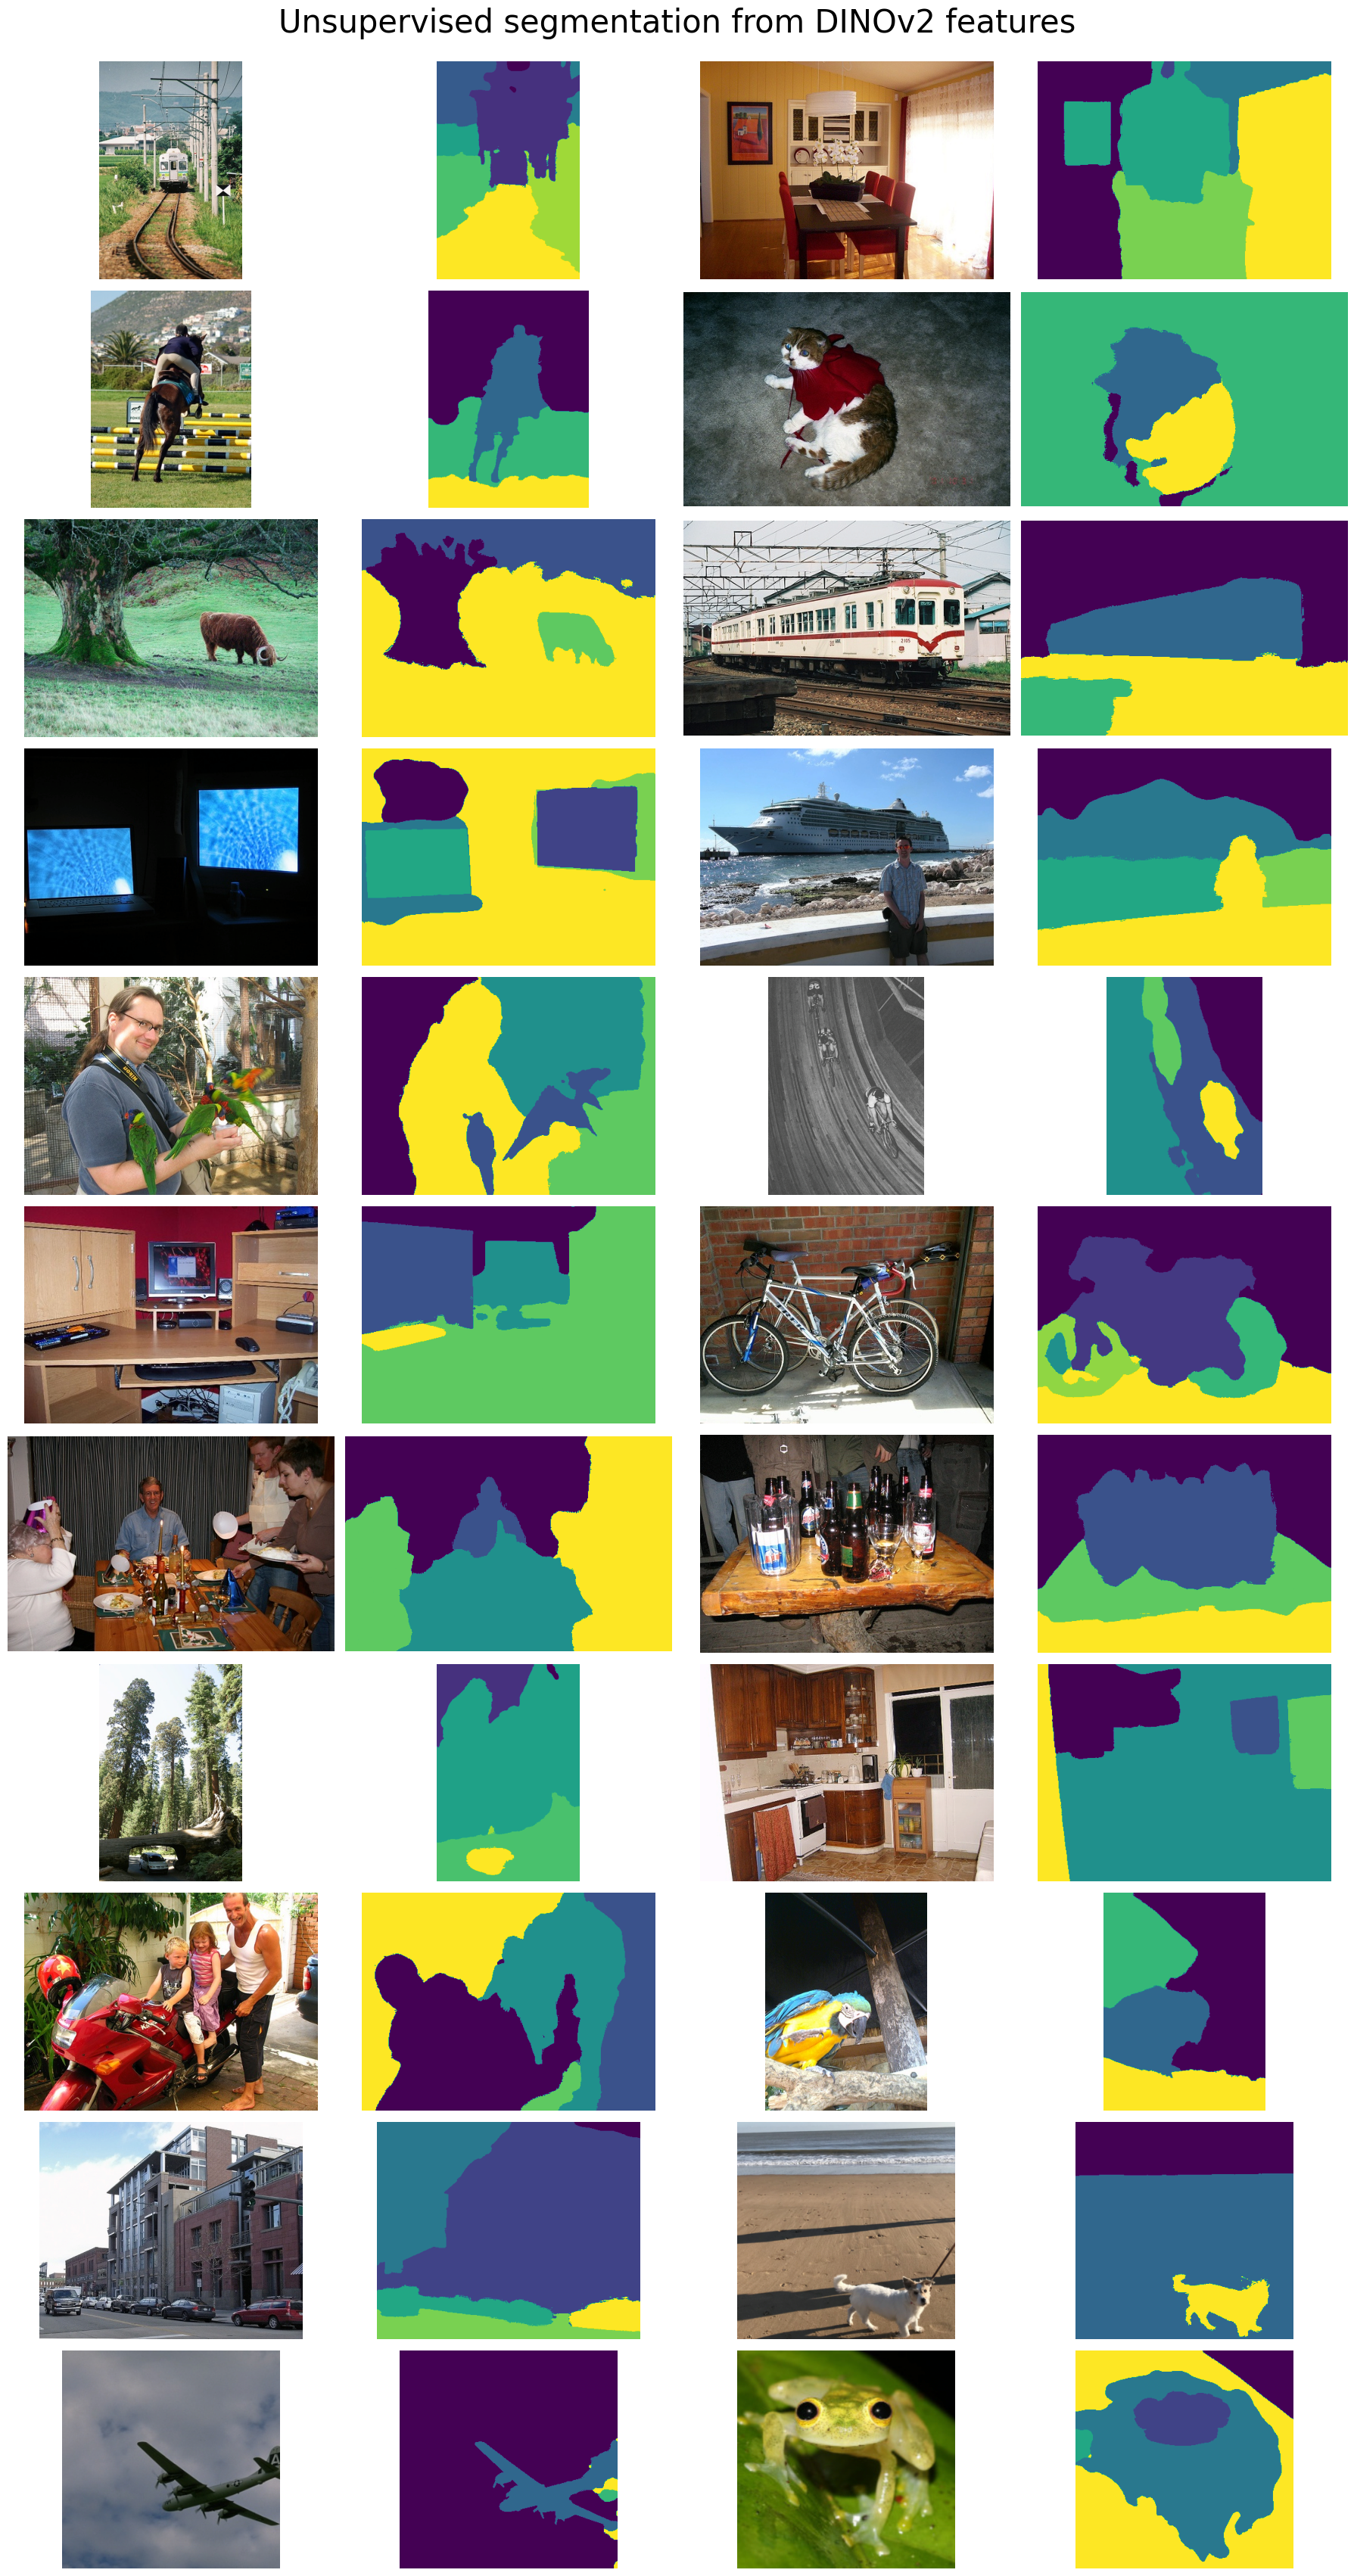

In [8]:

from math import ceil

N_COLS = 4
N_ROWS = ceil(len(voc_paths) / 2)
fig, axs = plt.subplots(nrows=N_ROWS, ncols=N_COLS)
fig.set_size_inches(18, 34)
print(axs.shape)

plt.suptitle("Unsupervised segmentation from DINOv2 features", fontsize=30, y=1.0)

I = 0
for i in range(0, len(voc_paths)):
    ax_1 = axs[i // 2, 2 * (i % 2)]
    ax_2 = axs[i // 2,  1 + 2 * (i % 2)]
    img = np.asarray(voc_imgs[i])
    h, w, c = img.shape
    seg = voc_segs[i].reshape((h, w)) + 1
    arr = label2rgb(seg, img, kind='avg')

    ax_1.imshow(img)
    ax_1.set_axis_off()
    ax_2.imshow(seg)
    ax_2.set_axis_off()
plt.tight_layout()